# Desarrollo de laboratorio 2 de aprendizaje por refuerzo
**Integrantes**:
- Carlos Castillo
- Daniel Psijas

**Profesor**:
- Javier Baladrón

A partir de la implementación del entorno de laboratorio 1, se implementará el desarrollo de un agente que utilice el método Monte Carlo, y otro que emplee el método Q-Learning. Además, se realizará un análisis del rendimiento de dichos agentes.

El desarrollo de este laboratorio estará dividido en 4 partes:
- Parte 1: Implementación del entorno
- Parte 2: Implementación de los agentes
- Parte 3: Simulación y rendimiento de los agentes
- Parte 4: Conclusiones

#Parte 1: Implementación del entorno
En esta parte se realizará al detalle el escenario del juego Bomberman a partir de los involucrados como también las reglas del juego.

**Instalación librerías**

Se instalan las librerías de Gymnasium de Farama y una librería adicional.

In [1]:
!pip install -U gymnasium pygame moviepy
!pip install gymnasium[box2d]
!python -m pip install dask[dataframe] --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: Could not build wheels for box2d-py, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.4 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2023.8.1
    Uninstalling dask-2023.8.1:
      Successfully uninstalled dask-2023.8.1
ERROR: pip's dependency resolver does not

**Importación de librerías adicionales**

Las siguiente librerías serán útiles para la implementación del entorno, así como las características de este mismo y de los agentes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import gymnasium as gym
from gym import spaces
from IPython.display import clear_output
import time
import dask
import pickle
rng = np.random.default_rng()

**Clase padre sujeto**

Se genera la clase padre que contendrá el simbolo, la posición y el estado del *jugador*, el *enemigo* y la *bomba* siendo las características comúnes entre ellas.

*Nota: Para la caja indestructible y destructibles se mantienen fuera de la clase sujeto, ya que se puede manipular de forma mas sencilla dentro del espacio de observación. En el caso de la posición de salida (que es la puerta), la mantendrá el jugador como posición final, en que coincidirá con la posición de una caja*.


In [ ]:
class Subject:

  # Constructor padre
  def __init__(self,symbol,pos,state):
    self.symbol = symbol  # Simbolo del sujeto
    self.pos = pos        # Posición del sujeto
    self.state = state    # Estado del sujeto

  # Obtener símbolo para imprimirlo en el escenario u otras comprobaciones
  def getSymbol(self):
    return self.symbol

  # Se obtiene la posición del elemento
  def getPos(self):
    return self.pos

  # Se cambia la posición del elemento
  def setPos(self,newPos):
    self.pos = newPos

  # Se obtiene el estado del sujeto
  def getState(self):
    return self.state

  # Se cambia el estado del sujeto
  def setState(self,state):
    self.state = state

A partir de lo anterior, se crean las 3 clases mencionadas anteriormente, con sus respectivas características.

**Clase hija Player (jugador)**

Esta clase solamente contendrá la posición actual del jugador, y la pocisión a la que debe llegar (la puerta de salida), con sus respectivos simbolos.



In [ ]:
# Clase jugador
class Player(Subject):
  # Inicialización del jugador
  def __init__(self,curr_pos,goal_Pos):
    self.goalPos = goal_Pos                 # Posición final
    self.symbolDoor = "P"                   # Simbolo de la puerta o la salida
    super().__init__("O",curr_pos,"vivo")   # Se obtiene el simbolo ("O"), posición actual y estado ("vivo" o "muerto") del jugador

  # Se obtiene la posición de la puerta de salida
  def getGoalPos(self):
    return self.goalPos

**Clase hija Enemy (enemigo)**

Esta clase contendrá las posiciónes del enemigo, el movimiento y dirección en torno al espacio, el estado en que se encuentra, y su simbolo.

In [ ]:
class Enemy(Subject):

  # Se construye el enemigo
  def __init__(self, curr_pos, movimiento, direccion):
    self.pos_enemi_start = curr_pos                     # Posición inicial del enemigo
    self.movimiento = movimiento                        # Movimiento del enemigo ("horizontal" o "vertical")
    self.direccion = direccion                          # Dirección del enemigo ("arriba", "abajo", "izquierda", "derecha")
    super().__init__("E",curr_pos,"vivo")   # Se obtiene el simbolo ("E"), la posición actual y el estado ("vivo" o "muerto") del enemigo

  # Se reinicia la posicion actual del enemigo
  def reset(self):
    # Estado de enemigo
    self.setState("vivo")

    # Reinicio posicion
    self.setPos(self.pos_enemi_start)

    #Reinicio movimiento
    if self.movimiento == "horizontal":
      self.direccion = "izquierda"
    else:
      self.direccion = "abajo"


  # Funcion de movimiento del enemigo
  def move(self,matriz):


    # Movimiento del enemigo de forma horizontal
    if self.movimiento == "horizontal":

      # Movimiento a la derecha
      if self.direccion == "derecha":
        nueva_pos = []
        nueva_pos.append(self.pos[0])
        nueva_pos.append(self.pos[1])

        nueva_pos[1] = nueva_pos[1] + 1
        # Si la siguiente posición es valida, entonces el enemigo se mueve
        if self.valid_position(nueva_pos, matriz):
          #self.setPos(nueva_pos)
          self.pos = nueva_pos

        # Si no, entonces cambia de dirección
        else:
          self.direccion = "izquierda"


      # Movimiento a la izquierda
      if self.direccion == "izquierda":
        nueva_pos = []
        nueva_pos.append(self.pos[0])
        nueva_pos.append(self.pos[1])

        nueva_pos[1] = nueva_pos[1] - 1
        # Si la siguiente posición es valida, entonces el enemigo se mueve
        if self.valid_position(nueva_pos, matriz):
          #self.setPos(nueva_pos)
          self.pos = nueva_pos

        # Si no, entonces cambia de dirección
        else:
          self.direccion = "derecha"

    # Movimiento del enemigo de forma vertical
    if self.movimiento == 'vertical':

      # Movimiento hacia arriba
      if self.direccion == "arriba":
        nueva_pos = []
        nueva_pos.append(self.pos[0])
        nueva_pos.append(self.pos[1])

        nueva_pos[0] = nueva_pos[0] - 1
        # Si la siguiente posición es valida, entonces el enemigo se mueve
        if self.valid_position(nueva_pos, matriz):
          #self.setPos(nueva_pos)
          self.pos = nueva_pos

        # Si no, entonces cambia de dirección
        else:
          self.direccion = "abajo"


      # Movimiento hacia abajo
      if self.direccion == "abajo":
        nueva_pos = []
        nueva_pos.append(self.pos[0])
        nueva_pos.append(self.pos[1])

        nueva_pos[0] = nueva_pos[0] + 1
        # Si la siguiente posición es valida, entonces el enemigo se mueve
        if self.valid_position(nueva_pos, matriz):
          #self.setPos(nueva_pos)
          self.pos = nueva_pos

        # Si no, entonces cambia de dirección
        else:
          self.direccion = "arriba"



  # Funcion para valida posición del enemigo
  def valid_position(self, pos, matriz):
    row, col = pos

    # Si el enemigo esta fuera del limite
    if row < 0 or col < 0 or row >= len(matriz) or col >= len(matriz[0]):
      return False

    # Si el enemigo toca un obstaculo
    if matriz[row,col] == '#' or matriz[row,col] == 'C' or matriz[row,col] == 'B' or matriz[row,col] == 'E':
      return False

    return True

**Clase hija Bomb (bomba)**

Esta clase contendrá la posición actual de la bomba en el escenario, al igual que su simbolo, y el tiempo de duración en que se encuentra activa.

In [ ]:
class Bomb(Subject):

  # Se construye la bomba
  def __init__(self, curr_pos):
    self.cuenta_regresiva = 6                 # Tiempo en que se encuentra activa la bomba
    super().__init__("B",curr_pos,"activo")   # Se obtiene el simbolo ("B"), la posición actual y el estado ("activo" o "destruido") de la bomba

  # Función que haga la cuenta regresiva para la explosión de la bomba
  def cronometro(self):
    self.cuenta_regresiva = self.cuenta_regresiva - 1

**Definición del espacio**

En esta etapa, se genera el escenario del juego bomberman, en que se generará la matriz base del juego, incluyendo las siguientes características presentes dentro de la matriz:
- El espacio vacío (.),
- Cajas indestructibles (#),
- Cajas destructibles (C).
- Enemigos (E).
- Jugador (O).

Además, se generarán los enemigos (E), y el jugador con su posición inicial y la posición final.

*Nota: Las bombas se incluirán con el simbolo (B) en caso de que el jugador las coloque. En el caso de la puerta de salida, se mostrará en la matriz con el simbolo (P) una vez que la caja que la contenga sea destruida.*

In [ ]:
from random import randint
# Funcion de genere el escenario del juego bomberman
# Entrada: Número de filas, Número de columnas, Número de cajas, Número de enemigos
def createMaze(filas, columnas, cajas, enemigos):

  # Se genera la matriz con los bloques indestructibles
  matrix = []
  for i in range(filas):
    fila = []
    for j in range(columnas):

      # Se rellenan los bordes con bloques indestructibles
      if j==0 or i==0 or j==(columnas-1) or i==(filas-1):
        fila.append("#")

      # Se rellena el espacio restante
      else:
        if i%2 != 0:
          fila.append('.')
        if i%2 == 0:
          if j%2 == 0:
            fila.append("#")
          else:
            fila.append('.')

    matrix.append(fila)

  # Se genera la posición inicial del jugador
  pos_inicial = []
  done = True
  while done:
    i = randint(0,filas-1)
    j = randint(0,columnas-1)

    if matrix[i][j] == ".":
      pos_inicial.append(i)
      pos_inicial.append(j)
      matrix[i][j] = "O"
      done = False

  # Se colocan las cajas destructibles en una posición vacía de la matriz
  for caja in range(cajas):
    done = True
    while done:
      i = randint(0,filas-1)
      j = randint(0,columnas-1)

      # Se verifica si la posición de la caja esta a un bloque del agente (para que el agente no quede atrapado entre las cajas)
      m = pos_inicial[0]
      n = pos_inicial[1]
      if (i!=m or j!=n) and matrix[i][j] == ".":
        if check_pos(i,j,m,n):
            matrix[i][j] = "C"
            done = False

  # Se genera la posición de los enemigos en la matriz, con sus movimientos iniciales
  enemi_list = []
  for e in range(enemigos):
    done = True
    while done:
      i = randint(0,filas-1)
      j = randint(0,columnas-1)

      # Se verifica si la posición del enemigo esta a un bloque del agente, para que el enemigo no se genere cerca del agente
      m = pos_inicial[0]
      n = pos_inicial[1]
      if (i!=m or j!=n) and (matrix[i][j] == ".") and (check_pos_enemy(i,j,enemi_list)==True):
        if check_pos(i,j,m,n):
          pos = [i,j]
          # Se acomoda el movimiento y dirección del enemigo según su posición
          if i%2 == 0 and j%2 != 0:
            nuevo_enemigo = Enemy(pos,"vertical","abajo")
            enemi_list.append(nuevo_enemigo)
            matrix[i][j] = "E"

          else:
            nuevo_enemigo = Enemy(pos,"horizontal","izquierda")
            enemi_list.append(nuevo_enemigo)
            matrix[i][j] = "E"

          done = False

  # Se genera la posición final
  pos_final = []
  done = True
  while done:
    i = randint(0,filas-1)
    j = randint(0,columnas-1)

    if matrix[i][j]== 'C':
      pos_final.append(i)
      pos_final.append(j)
      done = False

  # Se genera el jugador, almacenando la posición inicial y final
  player = Player(np.array(pos_inicial),np.array(pos_final))

  # Retonra: La matriz del espacio del juego, el listado de enemigos, el listado de cajas, y el jugador
  return matrix, enemi_list, player

#-----------------------------------------------------------------------------------------------
# Funcion que verifique la posicion de la caja y el enemigo con la posicion inicial
# i , j = Posicion inicial de la fila y columna
# m , n = Posicion de fila y columna del enemigo o la caja
def check_pos(i,j,m,n):
  if (i!=m or j!=n+1) and (i-1!=m or j!=n+1) and (i-1!=m or j!=n) and (i-1!=m or j!=n-1) and (i!=m or j!=n-1) and (i+1!=m or j!=n-1) and (i+1!=m or j!=n) and (i+1!=m or j!=n+1):
    return True
  return False

# Función que verique si el enemigo no ocupa la posición de otro enemigo
# i, j = Posicion fila y columna del enemigo
# enemies = Listado de los enemigos creados
def check_pos_enemy(i,j, enemies):
  for e in range(len(enemies)):
    m = enemies[e].pos_enemi_start[0]
    n = enemies[e].pos_enemi_start[1]

    if i==m and j==n:
      return False # El enemigo ya existe en la misma posición de otro enemigo

  # El enemigo esta en una posicion distinta a los otros enemigos
  return True


**Clase principal del entorno bomberman**

A continuación, se define la clase principal de juego bomberman *BombermanGameEnv* que hereda del entorno de gym.
En esta clase, se generará de forma personalizada el entorno del escenario del juego, incluyendo las siguientes funciones principales:
- reset()
- step()
- render()

Además, para complementar las clases anteriores, se definieron las siguientes clases secundarias:
- update_maze()
- _is_valid_position()
- put_bomb()
- _state_position()
- eliminar_entidades()
- eliminar_objetos()
- combinations()
- encodeState()
- decodeState()
- getState()

Cabe mencionar que en el entorno se definió los estados y las acciones de la siguiente manera:
- En el caso de los estados, se estableció como todas las combinaciónes posibles de los 4 espacios adyacentes (arriba, abajo, izquierda y derecha) a partir de la posición actual del jugador, en que cada espacio adyacente puede contener los simbolos que representan un espacio vacío, o una caja indestructible, o una caja destructible, o un enemigo, o una bomba, o la puerta de salida (escondida por caja o visible). Siendo representado por un array de los 4 símbolos en ese orden, además de un número que es proporcionado por el generador de todas las combinaciones posibles de estados para poder codificarlo.
- En el caso de las acciónes, se definió 5 posibles acciones que el agente puede realizar:
  - Acción 0 = El agente se mueve arriba del espacio.
  - Acción 1 = El agente se mueve abajo del espacio.
  - Acción 2 = El agente se mueve a la izquierda del espacio.
  - Acción 3 = El agente se mueve a la derecha del espacio.
  - Acción 4 = El agente coloca una bomba en su posición actual.

In [ ]:
class BombermanGameEnv(gym.Env):

  #---------------------------------------------------------------------------
  # CONSTRUCTOR DEL ENTORNO
  #---------------------------------------------------------------------------
  def __init__(self, n_filas, n_columnas, max_episode_steps = 500):
    # Se guarda la cantidad máxima de episodios y la repetición actual
    self.max_episode_steps = max_episode_steps
    self.current_step = 0

    # Se genera la semilla
    seed = random.randint(1,9999)

    # Número de cajas y enemigos
    if n_filas < 7 and n_columnas < 7:
      self.n_cajas = 2
      self.n_enemigos = 1

    else:
      self.n_cajas = random.randint(1,(n_filas*n_columnas-n_filas*2-n_columnas*2)//2)
      self.n_enemigos = random.randint(1,(n_filas*n_columnas-n_filas*2-n_columnas*2)//16)
    # Se obtiene la matriz, la lista de enemigos, y el jugador.
    maze, enemies, player = createMaze(n_filas, n_columnas, self.n_cajas, self.n_enemigos)

    # Definición de matriz inicial y actual
    self.maze_ini = np.array(maze)
    self.maze = np.array(maze)

    # Número de filas y columnas del espacio
    self.num_rows = n_filas
    self.num_cols = n_columnas

    # Jugador (player) y su posición inicial (start_pos)
    self.player = player
    self.start_pos = player.getPos()
    self.final_pos = player.getGoalPos()

    # Listado de enemigos
    self.enemies = enemies

    # Listado de bombas
    self.bombs = []

    # Espacio de acciónes:
    # 0 => El jugador se mueve arriba,
    # 1 => El jugador se mueve abajo,
    # 2 => El jugador se mueve a la izquierda,
    # 3 => El jugador se mueve a la derecha,
    # 4 => El jugador coloca una bomba.
    self.n_actions = 5
    self.action_space = spaces.Discrete(self.n_actions)

    # Rellenar el espacio de estados con todos los estados posibles gracias
    # a la funcion combinations
    self.stateSpace = []
    self.count = 0
    self.combinations(4,[],0,self.stateSpace)

    print("Estados posibles: ",self.stateSpace)
    self.render(True,0)

    # Cantidad de estados
    self.states = len(self.stateSpace)


  #---------------------------------------------------------------------------
  # FUNCIÓN RESET
  #---------------------------------------------------------------------------
  # Reiniciar estado del entorno
  # Si change es True, el entorno se reinicia a un estado aleatorio.
  # Si change es False, el entorno se reinicia al estado inicial.
  def reset(self, change):
    # Se reinicia la repetición actual
    self.current_step = 0

    # En caso de que el entorno se reinicie a un estado de forma aleatoria
    if change:
      # Se obtiene una nueva matriz, la lista de enemigos, y el jugador.
      maze, enemies, player = createMaze(self.num_rows, self.num_cols, self.n_cajas, self.n_enemigos)

      # Nueva matriz inicial y actual
      self.maze_ini = np.array(maze)
      self.maze = np.array(maze)

      # Restablecimiento de Jugador (player), su posición inicial (start_pos) y final (final_pos)
      self.player = player
      self.start_pos = player.getPos()
      self.final_pos = player.getGoalPos()

      # Nuevo listado de enemigos
      self.enemies = enemies

    else:
      # Se el estado del jugador
      self.player.setState("vivo")
      self.player.setPos(self.start_pos)

      # Se reinician el estado de cada enemigo
      for e in range(len(self.enemies)):
          self.enemies[e].reset()

      # Se reinicia el estado de la matriz. junto con las cajas destructibles.
      for i in range(self.num_rows):
        for j in range(self.num_cols):
          self.maze[i][j] = self.maze_ini[i][j]


    # Listado de bombas
    self.bombs = []

    # Retorno al nuevo estado inicial
    return self.getState()


  #---------------------------------------------------------------------------
  # FUNCIÓN STEP
  #---------------------------------------------------------------------------
  def step(self, action):
    #---------------------------------------------------------------------------
    # Movimiento de enemigos
    #---------------------------------------------------------------------------
    # Se mueven los enemigos siempre que esten vivos
    for e in range(len(self.enemies)):
      if self.enemies[e].getState() == "vivo":
        pos_a = self.enemies[e].getPos()  # Posicion actual del enemigo
        self.enemies[e].move(self.maze)   # Se actualiza la posición del enemigo
        pos_n = self.enemies[e].getPos()  # Posición nueva del enemigo
        self.update_maze(pos_a,pos_n,"E") # Se refleja el cambio en la matriz

    #---------------------------------------------------------------------------
    # Transición de estado por la acción del jugador
    #---------------------------------------------------------------------------
    # Se ejecuta la acción del agente
    new_pos = np.array(self.player.getPos())
    if action == 0:   # Ir arriba
      new_pos[0] -= 1
    elif action == 1: # Ir abajo
      new_pos[0] += 1
    elif action == 2: # Ir izquierda
      new_pos[1] -= 1
    elif action == 3: # Ir derecha
      new_pos[1] += 1
    elif action == 4: # Poner bomba
      self.put_bomb()


    #---------------------------------------------------------------------------
    # Checkear movimiento del jugador y validar penalización
    #---------------------------------------------------------------------------
    # Recompensa del episodio
    reward = 0.0

    # Revisar si el movimiento del jugador es válido
    if self._is_valid_position(new_pos):
      pos_a = self.player.getPos()      # Posicion actual del jugador
      self.player.setPos(new_pos)       # Se actualiza la posición del jugador
      pos_n = self.player.getPos()      # Posición nueva del jugador
      self.update_maze(pos_a,pos_n,"O") # Se refleja el cambio en la matriz
    else:
      reward -= 1.0                     # Se descuentan 1 por cada movimiento invalido

    #---------------------------------------------------------------------------
    # Actualizar el estado de cada bomba
    #---------------------------------------------------------------------------
    for b in range(len(self.bombs)):
      self.bombs[b].cronometro()
      i, j = self.bombs[b].getPos()
      if self.bombs[b].getState() == "activo":
        self.maze[i][j] = 'B'

    #---------------------------------------------------------------------------
    # Recompensa y estado del entorno
    #---------------------------------------------------------------------------
    # Se realiza el efecto de la acción para obtener el nuevo estado, además
    # este efecto retorna una recompensa dependiendo de lo que pasó.
    rewardReturn, terminal = self._state_position()
    reward += rewardReturn

    #---------------------------------------------------------------------------
    # Se termina el episodio si llega al tiempo máximo permitido
    #---------------------------------------------------------------------------
    truncated = False
    self.current_step +=1
    if self.current_step % self.max_episode_steps == 0:
        truncated = True

    info = {}

    # Retorno de datos
    return self.getState(), reward, terminal, truncated, info


  #---------------------------------------------------------------------------
  # FUNCIÓN RENDER
  #---------------------------------------------------------------------------
  # Se muestra el estado del entorno
  def render(self, permiso, episodio):
    # Se visualiza el estado del entorno siempre que esté permitido
    if permiso:
      # Se muestra el numero de episodio
      print("Episodio: ", episodio)

      # Se muestra la repetición actual
      print("Repetición número: ", self.current_step)

      # Se muestra el número de estado
      print("Estado: ",self.getState())

      # Se muestra la matriz
      for row in range(self.num_rows):
        for col in range(self.num_cols):
            print(self.maze[row][col], end="  ")
        print("\n")

      # Se muestra el estado del jugador
      print("Estado jugador: ",self.player.getState())

      # Se muestra la posición del jugador
      print("Posición del jugador: ",self.player.getPos())

      # Se muestra la posición de la puerta
      print("Posición de salida: ", self.final_pos)

      # Bombas activadas
      print("Número de bombas: ", len(self.bombs))

      # Enemigos
      for e in range(len(self.enemies)):
        if self.enemies[e].getState() == "vivo":
          print("Enemigo ", e+1," : ")
          print("   Posición:     ",self.enemies[e].getPos())
          print("   Movimiento:   ",self.enemies[e].movimiento)
          print("   Dirección:   ",self.enemies[e].direccion)
          print("\n")

      # Se pausa por 2 segundos
      time.sleep(2)


#---------------------------------------------------------------------------
# FUNCIONES SECUNDARIAS
#---------------------------------------------------------------------------
  # Función que mueva un enemigo o el jugador en la matriz
  def update_maze(self, pos_act, pos_new, symbol):
    i_a, j_a = pos_act
    i_n, j_n = pos_new
    self.maze[i_a,j_a] = "."
    self.maze[i_n,j_n] = symbol


#---------------------------------------------------------------------------
  # Funcion que valida la posición del jugador
  def _is_valid_position(self, pos):
    row, col = pos

    # Si el agente va a una caja indestructible
    if self.maze[row, col] == '#':
      return False

    # Si el agente toca una caja destructible
    if self.maze[row, col] == 'C':
      return False

    # Si el agente va a una bomba
    if self.maze[row, col] == 'B':
      return False

    return True


#------------------------------------------------------------------------------------
  # Funcion que pone solamente una bomba en un espacio de la matriz
  def put_bomb(self):
    i, j = self.player.getPos()
    if self.maze[i][j] == 'O':
      self.bombs.append(Bomb([i,j]))


#------------------------------------------------------------------------------------
  # Funcion para validar objeto de la posición actual del agente
  def _state_position(self):

    reward = -0.01 # Recompensa negativa por paso dado

    terminal = False
    # En caso de que el agente llegue a la posición final
    if np.array_equal(self.player.getPos(), self.final_pos):
      reward += 50.0
      terminal = True
      return reward, terminal

    # En caso de que el agente choque a un enemigo
    for e in range(len(self.enemies)):
      if self.enemies[e].getState() == "vivo":
        if np.array_equal(self.player.getPos(), self.enemies[e].getPos()):
          self.player.setState("muerto")
          reward -= 50.0
          terminal = True
          return reward, terminal

    # En caso de que una bomba explote (cuenta_regresiva = -1)
    for b in range(len(self.bombs)):
      if self.bombs[b].cuenta_regresiva == -1:

        # Se elimina cualquier enemigo, caja, o el jugador dentro del rango de explosión
        bi, bj = self.bombs[b].getPos()
        reward += self.eliminar_entidades(bi,bj)

        # Se elimina la bomba de la matriz, y se cambia su estado
        self.bombs[b].setState("destruido")
        posi_b, posj_b = self.bombs[b].getPos()
        self.maze[posi_b][posj_b] = "."

        # Checkear si el jugador está muerto
        if self.player.getState() == "muerto":
          reward -= 50.0
          terminal = True
          return reward, terminal

    # Se elimina las bombas destruidas
    self.bombs = [objeto for objeto in self.bombs if objeto.getState() != "destruido"]

    return reward, terminal


#------------------------------------------------------------------------------------
  # Funcion que actualice el estado de la matriz en caso de que una bomba explote
  def eliminar_entidades(self, fil, col):

    reward = 0.0

    # En caso de que la bomba explote en espacio cerrado (explosion horizontal)
    if  self.maze[fil-1][col] == '#' and self.maze[fil+1][col] == '#':
      if col+2 == self.num_cols:
        for r in range(3):
          reward += self.eliminar_objeto(fil, col-r)

      if col-2 == -1:
        for r in range(3):
          reward += self.eliminar_objeto(fil, col+r)

      if col+2 != self.num_cols and col-2 != -1:
        for r in range(3):
          reward += self.eliminar_objeto(fil, col+r-1)

    # En caso de que la bomba explote en espacio cerrado (explosion vertical)
    if self.maze[fil][col-1] == '#' and self.maze[fil][col+1] == '#':
      if fil+2 == self.num_rows:
        for r in range(3):
          reward += self.eliminar_objeto(fil-r, col)

      if fil-2 == -1:
        for r in range(3):
          reward += self.eliminar_objeto(fil+r, col)

      if fil+2 != self.num_rows and fil-2 != -1:
        for r in range(3):
          reward += self.eliminar_objeto(fil+r-1, col)

    # En caso de que la bomba explote en espacio abierto (explosion vertical y horizontal)
    if (self.maze[fil-1][col] == '#' and self.maze[fil+1][col] == '#') == False and (self.maze[fil][col-1] == '#' and self.maze[fil][col+1] == '#') == False:
      # Vertical
      for r in range(3):
          reward += self.eliminar_objeto(fil+r-1, col)
      # Horizontal
      for r in range(3):
          reward += self.eliminar_objeto(fil, col+r-1)

    return reward


#------------------------------------------------------------------------------------
  # Función que elimine un objeto, enemigo, caja de la matriz, incluyendo al jugador
  def eliminar_objeto(self, fil_e, col_e):

    reward = 0.0
    # En caso de que exista una caja en el rango de explosión
    if self.maze[fil_e][col_e] =='C':
      # Si la caja explotada esconde la puerta, se muestra
      if self.final_pos[0] == fil_e and self.final_pos[1] == col_e:
        self.maze[fil_e][col_e]= 'P'
        reward += 20.0  # Recompensa adicional por ser la caja de la puerta

      # Si no, se deja el espacio vacío
      if self.final_pos[0] != fil_e and self.final_pos[1] != col_e:
        self.maze[fil_e][col_e]= '.'

        # Recompensa de 5 por cada caja rota
        reward += 5.0

    # En caso de que exista un enemigo en el rango de explosion
    for e in range(len(self.enemies)):
      posi_e, posj_e = self.enemies[e].getPos()
      if posi_e == fil_e and posj_e == col_e:
        self.enemies[e].setState("muerto")
        self.maze[posi_e][posj_e] = '.'
        # Recompensa de 5 por cada enemigo derrotado
        reward += 5.0

    # En caso de que exista el jugador en el rango de explosion
    fil, col = self.player.getPos()
    if fil==fil_e and col==col_e:
      self.player.setState("muerto")

    return reward


# ----------------------------------------------------------------
  # Función que genera todas las combinaciónes de estados con el método de backtracking
  # (los estados son los 4 símbolos posibles adyacentes al jugador).
  # n: numero de casillas
  # grid: casillas
  # k: numero de elementos rellenados
  def combinations(self,n,grid,k,result):

      if(k == n):
          # Verificando condiciones imposibles del estado para no incluirlas
          if(grid.count('#') < n and grid.count('.') <= n and grid.count('P') <= 1 and grid.count('E') <= 4 and (grid.count('P') + grid.count('PC')) <= 1):

              # Añadir estado con su respectiva id al final del arreglo para codificarlo
              result.append(grid.copy() + [self.count])
              self.count += 1
          return

      else:
          c = ''
          # Sacando un elemento de cada símbolo posible para probar
          # combinaciones
          for i in range(7):

              if(i == 0):
                  c = '.' # Espacío vacío
              if(i == 1):
                  c = '#' # Caja indestructible
              if(i == 2):
                  c = 'C' # Caja destructible
              if(i == 3):
                  c = 'E' # Enemigo
              if(i == 4):
                  c = 'B' # Bomba
              if(i == 5):
                  c = 'PC' # Puerta escondida por caja destructible
              if(i == 6):
                  c = 'P' # Puerta visible

              # Agregar símbolo al arreglo para generar combinaciones y hacer
              # backtrack
              grid.append(c)
              self.combinations(n,grid,k+1,result)
              grid.pop(k)
              i = i - 1


#------------------------------------------------------------------------------------
  # Función que codifique el conjunto de símbolos en un estado
  def encodeState(self,states,grid):

      grid = np.array(grid)


      states = np.array(states)

      # Crear un array booleano indicando las posiciones donde grid coincide con cada estado
      equal = np.all(states[:, :4] == grid, axis=1)

      # Encontrar el índice del primer estado que coincide con grid
      index = np.argmax(equal)

      # Devolver el valor correspondiente a la columna 4 del estado encontrado o -1 si no se encuentra
      return int(states[index, 4]) if equal[index] else -1


#------------------------------------------------------------------------------------
  # Función que decodifique un número de estado a un conjunto de símbolos
  def decodeState(self,state,states):
      states = np.array(states)
      index = np.argmax((states[:, 4]).astype(int) == state)

      # Convertir el estado encontrado a un array de NumPy y devolver las primeras cuatro columnas
      return states[index, :4]


#------------------------------------------------------------------------------------
  # Función que obtenga el estado del jugador viendo los 4 puntos adyacentes
  # y codificandolos en un número
  def getState(self):
    symbols = []
    pi, pj = np.array(self.player.getPos())
    gi, gj = np.array(self.player.getGoalPos())

    matrix = np.array(self.maze)

    # 4 posiciones adyacentes al jugador
    poses = [[-1,0],[0,-1],[0,1],[1,0]]

    for pos in poses:
      symbol = matrix[pi+pos[0],pj+pos[1]]
      # Comprobar si está la puerta de salida dentro de una caja
      if(symbol == 'C' and pi+pos[0] == gi and pj+pos[1] == gj):
        symbols.append('PC')
      else:
        symbols.append(symbol)

    return self.encodeState(self.stateSpace,symbols)

**Prueba del funcionamiento del entorno**

Antes de implementar los agentes, se realizará una prueba del entorno para ver si funciona correctamente el funcionamiento de cada implementación realizado, además de observar el comportamiento del jugador ante diferentes recompensas.

*La lógica de la recompensas son las siguientes:*

**Recompensas por movimiento:**
- Por cada movimiento inválido que realiza el jugador, recibirá una penalización con recompensa -1.0
- Por cada movimiento válido del jugador, recibirá recompensa -0.01

**Recompensas por fin de juego:**
- Si el jugador llega a la puerta de salida, se acaba el episodio, y recibe recompensa 50.0
- Si el jugador es alcanzado por un enemigo, se muere, se acaba el episodio, y recibe recompensa -50.0
- Si el jugador es alcanzado por una bomba, se muere, se acaba el episodio, y recibe recompensa -50.0

**Recompensas por explosión de bomba**
- Si al explotar la bomba elimina una caja, recibe recompensa 5.0
- Si al explotar la bomba elimina la caja que contiene la puerta de salida, recibe recompensa 20.0
- Si al explotar la bomba elimina un enemigo, recibe recompensa 5.0
- Si al explotar la bomba no elimina nada, recibe recompensa 0.0

Estados posibles:  [['.', '.', '.', '.', 0], ['.', '.', '.', '#', 1], ['.', '.', '.', 'C', 2], ['.', '.', '.', 'E', 3], ['.', '.', '.', 'B', 4], ['.', '.', '.', 'PC', 5], ['.', '.', '.', 'P', 6], ['.', '.', '#', '.', 7], ['.', '.', '#', '#', 8], ['.', '.', '#', 'C', 9], ['.', '.', '#', 'E', 10], ['.', '.', '#', 'B', 11], ['.', '.', '#', 'PC', 12], ['.', '.', '#', 'P', 13], ['.', '.', 'C', '.', 14], ['.', '.', 'C', '#', 15], ['.', '.', 'C', 'C', 16], ['.', '.', 'C', 'E', 17], ['.', '.', 'C', 'B', 18], ['.', '.', 'C', 'PC', 19], ['.', '.', 'C', 'P', 20], ['.', '.', 'E', '.', 21], ['.', '.', 'E', '#', 22], ['.', '.', 'E', 'C', 23], ['.', '.', 'E', 'E', 24], ['.', '.', 'E', 'B', 25], ['.', '.', 'E', 'PC', 26], ['.', '.', 'E', 'P', 27], ['.', '.', 'B', '.', 28], ['.', '.', 'B', '#', 29], ['.', '.', 'B', 'C', 30], ['.', '.', 'B', 'E', 31], ['.', '.', 'B', 'B', 32], ['.', '.', 'B', 'PC', 33], ['.', '.', 'B', 'P', 34], ['.', '.', 'PC', '.', 35], ['.', '.', 'PC', '#', 36], ['.', '.', 'PC', 'C',

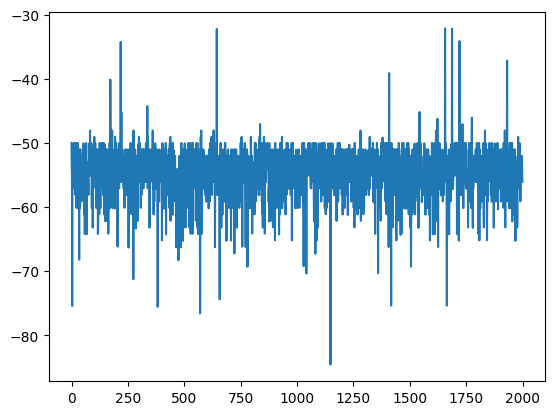

In [ ]:
# Datos de prueba
tam_fila_col = 5  # tamaño de Fila y columna
mostrar = False    # Variable para mostrar o no el escenario del entorno
iteraciones = 2000  # Numero de iteraciónes

# Se crea el entorno
env = BombermanGameEnv(tam_fila_col, tam_fila_col)

# Promedio de episodios
episodes = []
for episode in range(iteraciones):

    # Se obtiene un estado inicial aleatorio
    state = env.reset(False)
    env.render(mostrar,episode)

    return_episode = 0.0
    done = False
    while not done:

        # Selección de una acción aleatoria
        action = env.action_space.sample()

        # Muestra una sola transición
        next_state, reward, terminal, truncated, info = env.step(action)

        # Ir al siguiente estado
        state = next_state

        # Retorno de recompensa
        return_episode += reward

        # Función render
        env.render(mostrar,episode)

        # Fin del episodio
        done = terminal or truncated

    # Se agrega el promedio de episodio
    episodes.append(return_episode)
    print(episode)

# Gráfico del comportamiento del entorno
plt.plot(episodes)

#Parte 2: Implementación de los agentes.

Una vez hecho el entorno, ahora se realizarán los agentes. Para ello, se realizará dos tipos principales de agentes: el agente que usa el método de *Monte Carlo*, y otro agente que use el método *Q-Learning*.


**Agente Monte Carlo**

La siguiente clase permite generar el método Monte Carlo, con la acción que realizará, la actualización de los valores de Q, y la función de entrenamiento.

In [ ]:
class MonteCarloAgent:

    # Método que inicialize el agente Monte Carlo
    def __init__(self, env, gamma, epsilon, alpha):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha

        ns = self.env.states
        na = env.n_actions

        self.Q = np.zeros((ns,na))

    # Seleccionar acción con épsilon-greedy
    def act(self, state):


        state = int(state)
        action = rng.choice(np.where(self.Q[state,:] == self.Q[state, :].max())[0])

        if rng.random() < self.epsilon:
            action = self.env.action_space.sample()

        return action

    # Actualización de los valores Q mediante el estado, la acción, y la recompensa recibira en el episodio
    def update(self, episode):

        return_episode = 0.0

        for state, action, reward in reversed(episode):

            # Calcular el retorno
            return_episode = reward + self.gamma * return_episode

            # Actualizar los Q-Valores
            self.Q[state,action] += self.alpha * (return_episode - self.Q[state,action])

    # Entrenamiento del agente
    def train(self, nb_episodes, mostrar, choice, recorder=False):

        # Returns and steps
        returns = []
        steps = []

        for episode in range(nb_episodes):

          # Comienzo de simulación del episodio
          done = False
          state = self.env.reset(choice) # Reseteo a un estado aleatorio o el estado inicial
          return_episode = 0.
          nb_steps = 0


          # Guardar transiciones
          transitions = []

          while not done:
            # Se escoge una acción
            action = self.act(state)
            # Se obtiene la transición
            next_state, reward, terminal, truncated, info = self.env.step(action)

            transitions.append([state, action, reward])

            # Se mueve al siguiente estado
            state = next_state

            # Fin del episodio
            done = terminal or truncated

            # Se muesta el espacio si mostrar = True
            self.env.render(mostrar,episode)

            nb_steps += 1

            return_episode += reward


          # Actualizar las estimaciones del agente después del episodio
          self.update(transitions)


          returns.append(return_episode)
          steps.append(nb_steps)

        return returns, steps

**Agente Q-Learning**

La siguiente clase permite generar el método Q-Learning, con la acción que realizará, la actualización de los valores de Q, y la función de entrenamiento.

In [ ]:
class QLearningAgent:

    # Método que inicialize el agente Q-Learning
    def __init__(self, env, gamma, epsilon, decay_epsilon, alpha):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay_epsilon = decay_epsilon
        self.alpha = alpha

        ns = self.env.states
        na = env.n_actions

        self.Q = np.zeros((ns,na))

    # Seleccionar la acción
    def act(self, state):

        state = int(state)

        action = rng.choice(np.where(self.Q[state,:] == self.Q[state,:].max())[0])

        if rng.random() < self.epsilon:
            action = self.env.action_space.sample()

        return action

    # Actualización de los valores Q mediante el estado, la acción, recompensa, y el estado siguiente
    def update(self, state, action, reward, next_state, done):

        # Estimación de las recompensas futuras
        target = reward

        if not done:
            target += self.gamma * self.Q[next_state,:].max()

        # Actualizar Q valor
        self.Q[state,action] += self.alpha * (target - self.Q[state,action])

        # Disminuir épsilon
        self.epsilon = self.epsilon * (1 - self.decay_epsilon)

    # Entrenamiento del agente
    def train(self, nb_episodes, mostrar, choice, recorder=None):

        returns = []
        steps = []

        for episode in range(nb_episodes):


            state = self.env.reset(choice) # Reseteo a un estado aleatorio o el estado inicial
            done = False
            nb_steps = 0


            return_episode = 0.0


            while not done:


                action = self.act(state)

                next_state, reward, terminal, truncated, info = self.env.step(action)

                # Usar los efectos vistos hasta ahora de ejecutar la acción para
                # actualizar la estimación de el Q óptimo.
                self.update(state, action, reward, next_state, done)


                state = next_state


                # Se muesta el espacio si mostrar = True
                self.env.render(mostrar,episode)

                nb_steps += 1

                return_episode += reward


                done = terminal or truncated


            # Store info
            returns.append(return_episode)
            steps.append(nb_steps)


        return returns, steps



#Parte 3: Simulación y rendimiento de los agentes

Una vez terminados de crear los agentes, ahora si se comienza con las simulaciónes.

**Entrenamiento de los agente**

Para facilitar las pruebas de rendimiento, se tiene la función *trainAgents*, esta función permitirá realizar el entrenamiento de ambos agentes (uno con el método MonteCarlo y otro con el método Q-Learning) a partir de ciertos parámetros relevantes que van variando por cada prueba que se realizará más adelante. Los parámetros a considerar son los siguientes:

- gamma
- epsilon
- alfa
- decay_epsilon

Además, se considerarán los siguientes parámetros adicionales para complementar algunas pruebas de rendimiento.

- np_episodes: Número de episodios para entrenar el agente
- filas: Número de filas del escenario
- columnas: Número de columnas del escenario
- mostrar: Número booleano que muestra el estado actual del entorno.
          Si es True se muestra la información actual del entorno, si el False no se muestra,
- change: Booleano que indica el tipo de reinicio del estado al terminar un   episodio. Se encuentra como parámetro en la función *reset()*
          Si es True, se reinicia a un estado aleatorio (escenario que tenga las posiciones diferentes de enemigos, cajas, y el jugador).
          Si es False, se reinicia al estado inicial (escenario que tena las posiciones fijas iniciales de enemigos, cajas, y el jugador)

Cabe mencionar que el entrenamiento de ambos agente se realizará de forma paralela, en que el tiempo de ejecución influirá mucho en el valor de algunos parámetros

In [ ]:
def trainAgents(gamma,epsilon,alpha,nb_episodes,decay_epsilon,filas,columnas,mostrar,change):

  # Creando el entorno aleatorio
  env = BombermanGameEnv(filas, columnas)

  # Creando los agentes MonteCarlo y Q Learning
  agent = MonteCarloAgent(env, gamma, epsilon, alpha)
  agent2 = QLearningAgent(env,gamma,epsilon,decay_epsilon,alpha)

  # Creando las funciones de entrenamiento con delayed de dask para poder ejecutarlas de forma paralela
  train = dask.delayed(agent.train)(nb_episodes,mostrar,change)
  train2 = dask.delayed(agent2.train)(nb_episodes,mostrar,change)

  # Ejecutando de forma paralela los entrenamientos para los dos agentes.
  result, result2 = dask.compute(train,train2)

  # Se guardan los resultados de las recompensas y la cantidad de pasos realizados en ambos agentes
  returns, steps = result
  returns2, steps2 = result2

  # Gráfico que muestra el comportamiento de las recompensas y los pasos ejecutados en el agente de MonteCarlo
  plt.figure(figsize=(10, 6))
  plt.subplot(121)
  plt.plot(returns)
  plt.xlabel("Episodes MC")
  plt.ylabel("Returns MC")
  plt.subplot(122)
  plt.plot(steps)
  plt.xlabel("Episodes MC")
  plt.ylabel("Steps MC")
  plt.show()

  print()

  # Gráfico que muestra el comportamiento de las recompensas y los pasos ejecutados en el agente de MonteCarlo
  plt.figure(figsize=(10, 6))
  plt.subplot(121)
  plt.plot(returns2)
  plt.xlabel("Episodes Q")
  plt.ylabel("Returns Q")
  plt.subplot(122)
  plt.plot(steps2)
  plt.xlabel("Episodes Q")
  plt.ylabel("Steps Q")
  plt.show()

  print()

  # Se muestra los valores de Q predominantes, el Q máximo del agente monte Carlo, y el estado dominante
  for i in range(0,len(agent.Q)):
    for j in range(0,len(agent.Q[i])):
        if(agent.Q[i,j] > 0):
          print(agent.Q[i,j],i,j)

  print()
  print(np.max(agent.Q))
  print(np.unravel_index(np.argmax(agent.Q),agent.Q.shape))

  # Se muestra los valores de Q predominantes, el Q máximo del agente Q-Learning, y el estado dominante
  for i in range(0,len(agent2.Q)):
    for j in range(0,len(agent2.Q[i])):
        if(agent2.Q[i,j] > 0):
          print(agent2.Q[i,j],i,j)

  print()
  print(np.max(agent2.Q))
  print(np.unravel_index(np.argmax(agent2.Q),agent2.Q.shape))

  # Se retorna ambos agentes entrenados
  return agent, agent2

**PRUEBA 1: Entrenamiento de ambos agente en un tablero pequeño y fijo**

En esta prueba se creará un tablero pequeño (tamaño de 5x5) y fijo, es decir, que siempre tenga las cajas, los enemigos y la puerta en la
misma posición (change = False). Luego, se entrena ambos agentes en este tablero y se muestra en un gráfico el rendimiento del entrenamiento.


Estados posibles:  [['.', '.', '.', '.', 0], ['.', '.', '.', '#', 1], ['.', '.', '.', 'C', 2], ['.', '.', '.', 'E', 3], ['.', '.', '.', 'B', 4], ['.', '.', '.', 'P', 5], ['.', '.', '#', '.', 6], ['.', '.', '#', '#', 7], ['.', '.', '#', 'C', 8], ['.', '.', '#', 'E', 9], ['.', '.', '#', 'B', 10], ['.', '.', '#', 'P', 11], ['.', '.', 'C', '.', 12], ['.', '.', 'C', '#', 13], ['.', '.', 'C', 'C', 14], ['.', '.', 'C', 'E', 15], ['.', '.', 'C', 'B', 16], ['.', '.', 'C', 'P', 17], ['.', '.', 'E', '.', 18], ['.', '.', 'E', '#', 19], ['.', '.', 'E', 'C', 20], ['.', '.', 'E', 'E', 21], ['.', '.', 'E', 'B', 22], ['.', '.', 'E', 'P', 23], ['.', '.', 'B', '.', 24], ['.', '.', 'B', '#', 25], ['.', '.', 'B', 'C', 26], ['.', '.', 'B', 'E', 27], ['.', '.', 'B', 'B', 28], ['.', '.', 'B', 'P', 29], ['.', '.', 'P', '.', 30], ['.', '.', 'P', '#', 31], ['.', '.', 'P', 'C', 32], ['.', '.', 'P', 'E', 33], ['.', '.', 'P', 'B', 34], ['.', '#', '.', '.', 35], ['.', '#', '.', '#', 36], ['.', '#', '.', 'C', 37], ['

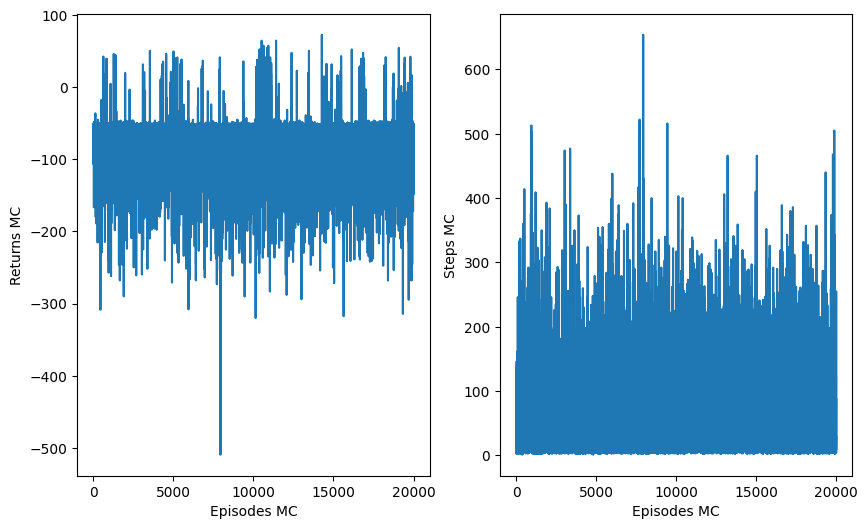

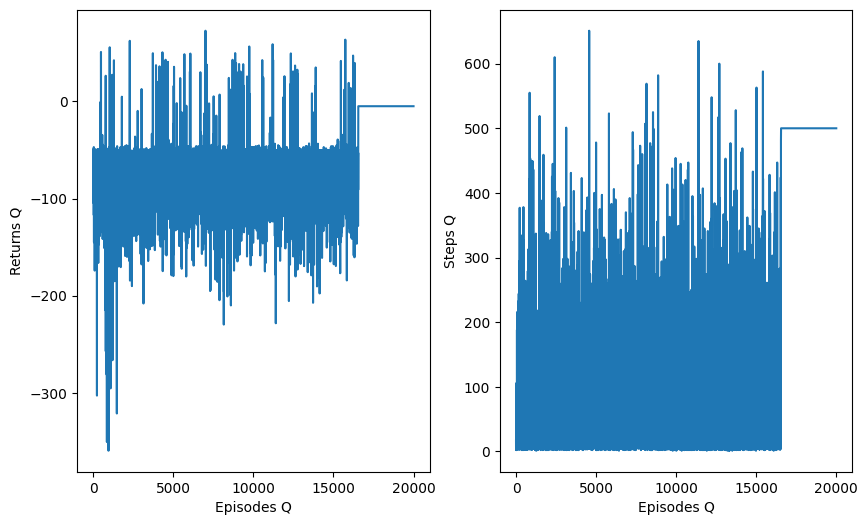


1.733135480854307 45 0
8.097750724548495 66 0
10.720605723523411 66 1
2.201966600552205 66 2
46.00946874392762 66 3
7.519698256551618 66 4
2.013092116613397 865 0
5.084128 865 1
1.0395112722260322 865 2
20.638707375624328 865 3

46.00946874392762
(66, 3)
15.083287898114348 36 3
1.7721979270742845 45 0
7.749480051228093 66 1
22.7675744250986 865 3

22.7675744250986
(865, 3)


In [ ]:
# Parametros
gamma = 0.6           # Valor gamma
epsilon = 0.3         # Valor epsilon
alpha = 0.05          # Valor alfa
nb_episodes = 20000   # Número de episodios
mostrar = False       # No se muestra el estado actual del entorno
change = False        # Tablero fijo

decay_epsilon = 0.01

filas = 5             # Tamaño pequeño de filas
columnas = 5          # Tamaño pequeño de columnas

# Entrenar agentes con los parámetros especificados
agent, agent2 = trainAgents(gamma,epsilon,alpha,nb_episodes,decay_epsilon,filas,columnas,mostrar,change)

**PRUEBA 2: Prueba del efecto de la tasa de aprendizaje y el factor de descuento en el tablero pequeño**

En esta prueba se observará el efecto de la tasa de aprendizaje y el factor de descuento en el entrenamiento de los agentes para el tablero pequeño. En este caso, el factor de descuento disminuirá y la tasa de aprendizaje aumentará.

Episodio:  0
Repetición número:  0
Estado:  276
#  #  #  #  #  

#  .  O  .  #  

#  .  #  .  #  

#  C  E  C  #  

#  #  #  #  #  

Estado jugador:  vivo
Posición del jugador:  [1 2]
Posición de salida:  [3 1]
Número de bombas:  0
Enemigo  1  : 
   Posición:      [3, 2]
   Movimiento:    horizontal
   Dirección:    izquierda




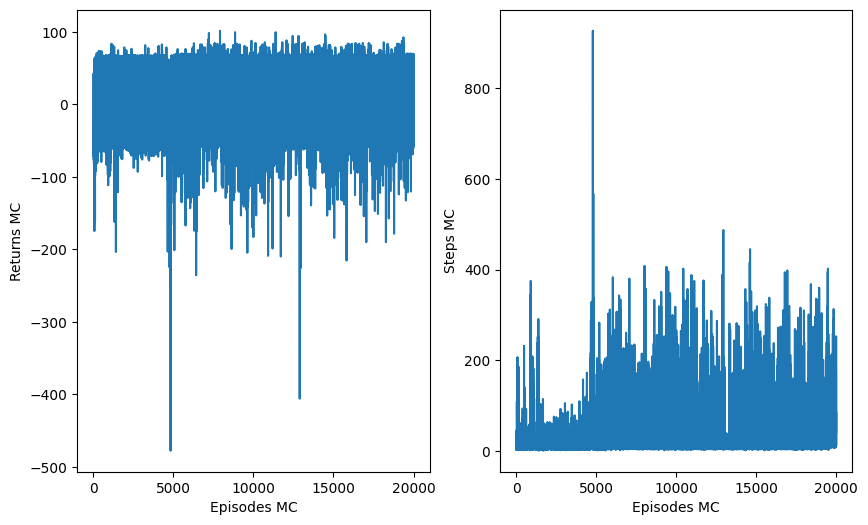

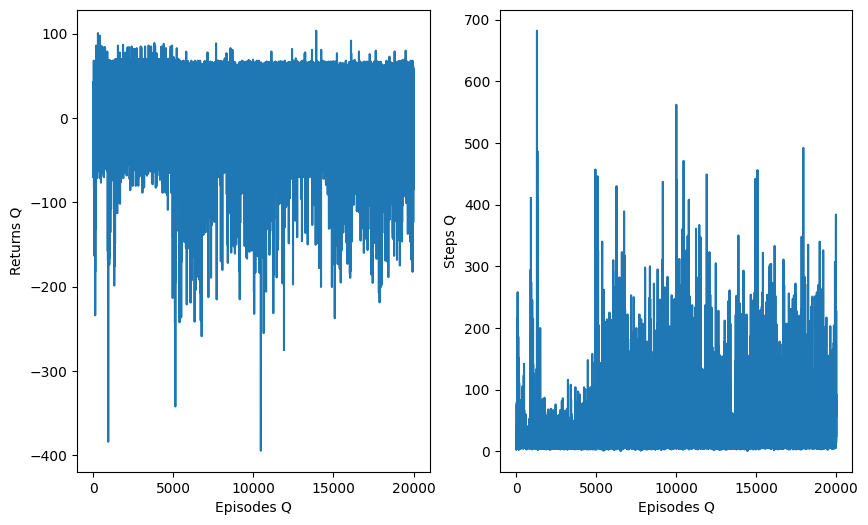


2.6007134906916267 52 0
23.231476558968822 52 1
33.55035332923407 52 2
5.415498752656102 52 3
22.23575196322243 52 4
0.5126499324705128 54 0
4.334573147313357 55 0
47.7264576081741 55 1
26.704546268713692 55 2
29.678701507483243 55 4
0.03982883161296128 57 0
1.2948197475503986 58 1
5.121996853644748 276 2
0.0734824451283224 282 1
0.04655601464130172 282 2
8.27070212735674 290 2
0.13542064852128521 290 3
1.5225355525014899 304 0
0.7462529506369407 304 1
11.179658709903821 304 2
0.3771894145474527 304 3
1.1567512191380251 304 4
0.7016662177442966 320 1
8.073106174298015 324 0
6.6663963851813985 324 1
5.1302756317461595 324 2
11.630693594643727 324 3
5.641799578062021 324 4
0.4999 424 2
0.1630631928332183 1151 0
48.40206870584385 1151 1
8.88400236968439 1154 0
18.947000778229143 1154 1
32.15477576706748 1154 2
8.06071699115599 1154 4
0.3151557267899426 1623 1
6.443677438276215 1623 4

48.40206870584385
(1151, 1)
22.20418193343494 52 4
34.640993301072115 55 1
0.034228218393974455 56 1
0.2

In [ ]:
# Parametros
gamma = 0.7           # Valor gamma
epsilon = 0.1         # Valor epsilon
alpha = 0.01          # Valor alfa
nb_episodes = 20000   # Número de episodios
mostrar = False       # No se muestra el estado actual del entorno
change = False        # Tablero fijo

decay_epsilon = 0.01

filas = 5
columnas = 5

trainAgents(gamma,epsilon,alpha,nb_episodes,decay_epsilon,filas,columnas,mostrar,change)

**PRUEBA 3: Entrenamiento de agentes ante tablero fijo más grande**

En esta prueba se observará el efecto de entrenar los agentes para que interactúe en un tablero fijo más gránde (tamaño de 9x9). Se utilizará los mismos parámetros de la prueba 2, a diferencia del tamaño de filas y columnas del tablero

In [ ]:
# Parametros
gamma = 0.7           # Valor gamma
epsilon = 0.1         # Valor epsilon
alpha = 0.01          # Valor alfa
nb_episodes = 20000   # Número de episodios
mostrar = False       # No se muestra el estado actual del entorno
change = False        # Tablero fijo

decay_epsilon = 0.01

filas = 9
columnas = 9

trainAgents(gamma,epsilon,alpha,nb_episodes,decay_epsilon,filas,columnas,mostrar,change)

Estados posibles:  [['.', '.', '.', '.', 0], ['.', '.', '.', '#', 1], ['.', '.', '.', 'C', 2], ['.', '.', '.', 'E', 3], ['.', '.', '.', 'B', 4], ['.', '.', '.', 'PC', 5], ['.', '.', '.', 'P', 6], ['.', '.', '#', '.', 7], ['.', '.', '#', '#', 8], ['.', '.', '#', 'C', 9], ['.', '.', '#', 'E', 10], ['.', '.', '#', 'B', 11], ['.', '.', '#', 'PC', 12], ['.', '.', '#', 'P', 13], ['.', '.', 'C', '.', 14], ['.', '.', 'C', '#', 15], ['.', '.', 'C', 'C', 16], ['.', '.', 'C', 'E', 17], ['.', '.', 'C', 'B', 18], ['.', '.', 'C', 'PC', 19], ['.', '.', 'C', 'P', 20], ['.', '.', 'E', '.', 21], ['.', '.', 'E', '#', 22], ['.', '.', 'E', 'C', 23], ['.', '.', 'E', 'E', 24], ['.', '.', 'E', 'B', 25], ['.', '.', 'E', 'PC', 26], ['.', '.', 'E', 'P', 27], ['.', '.', 'B', '.', 28], ['.', '.', 'B', '#', 29], ['.', '.', 'B', 'C', 30], ['.', '.', 'B', 'E', 31], ['.', '.', 'B', 'B', 32], ['.', '.', 'B', 'PC', 33], ['.', '.', 'B', 'P', 34], ['.', '.', 'PC', '.', 35], ['.', '.', 'PC', '#', 36], ['.', '.', 'PC', 'C',

**PRUEBA 4: Entrenamiento de tablero pequeño y variable**

En esta prueba se realiza el entrenar a ambos agentes con un tablero pequeño (tamaño de 5x5) y variable (change = True), en este caso, en cada episodio se realizará con un tablero diferente para mostrar su capacidad de generalización.

Estados posibles:  [['.', '.', '.', '.', 0], ['.', '.', '.', '#', 1], ['.', '.', '.', 'C', 2], ['.', '.', '.', 'E', 3], ['.', '.', '.', 'B', 4], ['.', '.', '.', 'PC', 5], ['.', '.', '.', 'P', 6], ['.', '.', '#', '.', 7], ['.', '.', '#', '#', 8], ['.', '.', '#', 'C', 9], ['.', '.', '#', 'E', 10], ['.', '.', '#', 'B', 11], ['.', '.', '#', 'PC', 12], ['.', '.', '#', 'P', 13], ['.', '.', 'C', '.', 14], ['.', '.', 'C', '#', 15], ['.', '.', 'C', 'C', 16], ['.', '.', 'C', 'E', 17], ['.', '.', 'C', 'B', 18], ['.', '.', 'C', 'PC', 19], ['.', '.', 'C', 'P', 20], ['.', '.', 'E', '.', 21], ['.', '.', 'E', '#', 22], ['.', '.', 'E', 'C', 23], ['.', '.', 'E', 'E', 24], ['.', '.', 'E', 'B', 25], ['.', '.', 'E', 'PC', 26], ['.', '.', 'E', 'P', 27], ['.', '.', 'B', '.', 28], ['.', '.', 'B', '#', 29], ['.', '.', 'B', 'C', 30], ['.', '.', 'B', 'E', 31], ['.', '.', 'B', 'B', 32], ['.', '.', 'B', 'PC', 33], ['.', '.', 'B', 'P', 34], ['.', '.', 'PC', '.', 35], ['.', '.', 'PC', '#', 36], ['.', '.', 'PC', 'C',

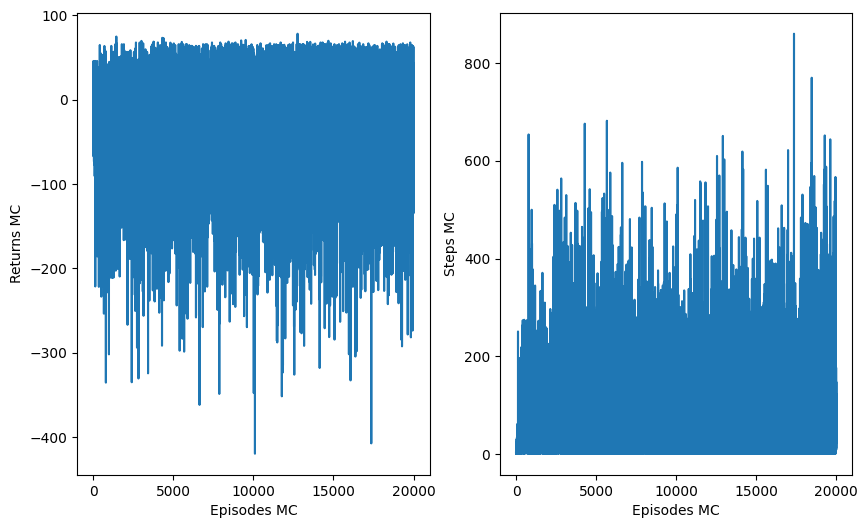

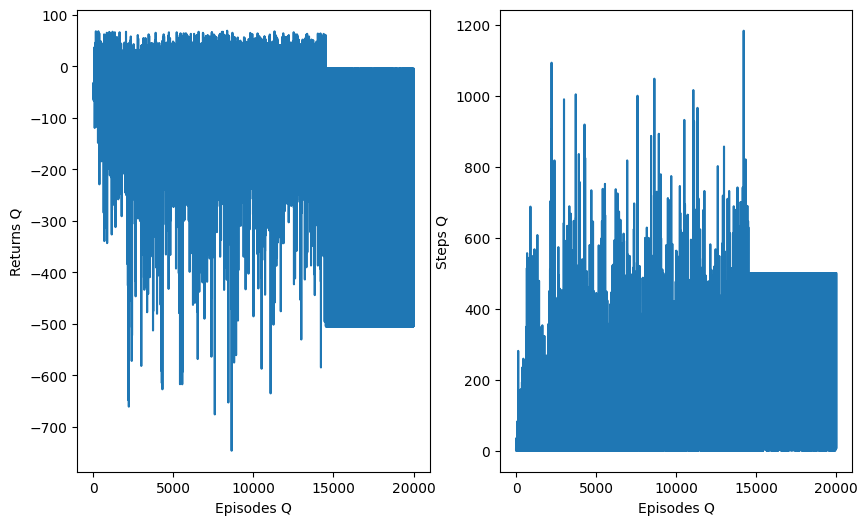


0.47727662685190264 58 0
41.56830320783356 58 1
2.0961404819932516 58 2
2.0845558611047412 58 3
1.7874636124049883 58 4
1.0852198184124684 86 3
0.4999 256 2
0.5072444750554684 256 3
0.14029217711393585 288 0
10.134811698600187 288 2
1.1897722514284168 288 3
1.32925369 288 4
3.4095165463587556 316 0
1.0983120067185326 316 1
1.5434941771772765 316 2
42.83853716463593 316 3
1.9500996112382616 316 4
3.18057691953703 326 2
3.39605325812957 467 1
0.22778099999999998 495 0
0.33983 495 2
7.759358928981281 495 3
2.7001783454679744 525 0
1.8524650540524057 525 1
3.957883947957396 525 2
2.9695675986729735 525 3
27.969967684317922 525 4
0.39580722921947753 529 3
0.6762617000000001 545 0
11.03003644982743 545 2
1.8637869569812975 1107 2
4.231886270830552 1157 1
12.526538010670562 1505 0
0.33983 1505 3
12.394113198523767 1525 0
0.33983 1525 1
0.06166835030272555 1525 2
0.7687856778087777 1525 3
0.15954678931676797 1525 4
24.796609241142992 1529 0
0.21238828455764489 1529 1
0.6842073307936809 1529 2

(<__main__.MonteCarloAgent at 0x7e5d7ce23310>,
 <__main__.QLearningAgent at 0x7e5d7ce23340>)

In [ ]:
# Parametros
gamma = 0.7           # Valor gamma
epsilon = 0.1         # Valor epsilon
alpha = 0.01          # Valor alfa
nb_episodes = 20000   # Número de episodios
mostrar = False       # No se muestra el estado actual del entorno
change = True         # Tablero variable

decay_epsilon = 0.01

filas = 5
columnas = 5

trainAgents(gamma,epsilon,alpha,nb_episodes,decay_epsilon,filas,columnas,mostrar,change)

**PRUEBA 5: Prueba del efecto al cambiar dos parámetros del método**

En esta prueba, se escogerán dos parámetros y se medirá el rendimiento del agente al cambiar los valores de estos parámetros y se comparará el rendimiento de distintas configuraciones mediante un gráfico. En este caso, se utilizará los mismos parámetros de la prueba 4, la diferencia que se aumentará los parámetros de epsilon y la tasa de aprendizaje.

Estados posibles:  [['.', '.', '.', '.', 0], ['.', '.', '.', '#', 1], ['.', '.', '.', 'C', 2], ['.', '.', '.', 'E', 3], ['.', '.', '.', 'B', 4], ['.', '.', '.', 'PC', 5], ['.', '.', '.', 'P', 6], ['.', '.', '#', '.', 7], ['.', '.', '#', '#', 8], ['.', '.', '#', 'C', 9], ['.', '.', '#', 'E', 10], ['.', '.', '#', 'B', 11], ['.', '.', '#', 'PC', 12], ['.', '.', '#', 'P', 13], ['.', '.', 'C', '.', 14], ['.', '.', 'C', '#', 15], ['.', '.', 'C', 'C', 16], ['.', '.', 'C', 'E', 17], ['.', '.', 'C', 'B', 18], ['.', '.', 'C', 'PC', 19], ['.', '.', 'C', 'P', 20], ['.', '.', 'E', '.', 21], ['.', '.', 'E', '#', 22], ['.', '.', 'E', 'C', 23], ['.', '.', 'E', 'E', 24], ['.', '.', 'E', 'B', 25], ['.', '.', 'E', 'PC', 26], ['.', '.', 'E', 'P', 27], ['.', '.', 'B', '.', 28], ['.', '.', 'B', '#', 29], ['.', '.', 'B', 'C', 30], ['.', '.', 'B', 'E', 31], ['.', '.', 'B', 'B', 32], ['.', '.', 'B', 'PC', 33], ['.', '.', 'B', 'P', 34], ['.', '.', 'PC', '.', 35], ['.', '.', 'PC', '#', 36], ['.', '.', 'PC', 'C',

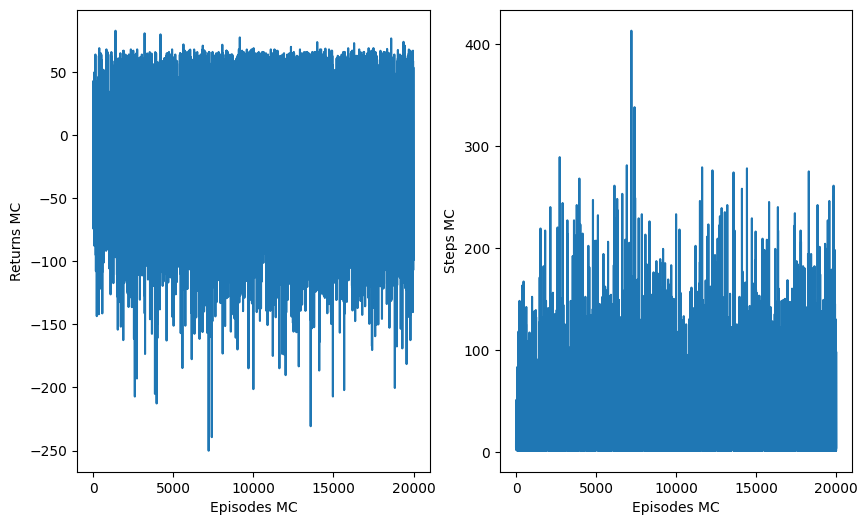

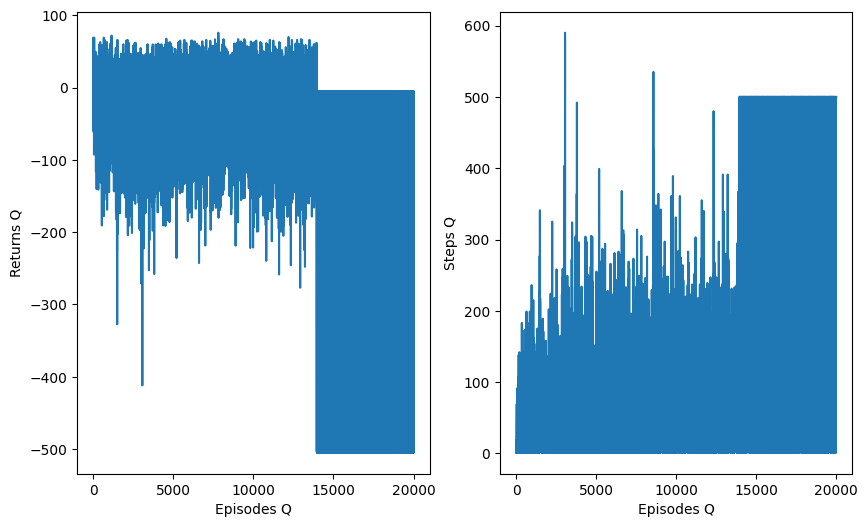


6.10677761022691 58 0
36.015431900527005 58 1
15.955931701505476 58 2
12.83199738043293 58 3
16.565422117758885 58 4
0.36655441499999997 256 0
0.5829255275 256 1
9.915227533078125 256 2
1.1275952775000007 256 3
1.3741225568713413 286 2
7.214820943516823 288 0
39.18974951100118 288 1
20.05782191295141 316 0
19.87435575098118 316 1
0.572249154964501 316 2
30.8945091545148 316 3
8.440305782377365 316 4
0.6202524563269973 326 1
8.817903678443852 326 2
1.5758948182213945 353 2
1.7828209150000005 353 3
0.8317334999999999 359 1
1.9491500000000004 359 2
5.994965259139822 359 3
2.4995000000000003 359 4
0.7361509149999999 386 4
4.8740250000000005 467 4
1.4901713259325005 495 2
31.152460525772792 495 3
13.959040124831477 525 0
15.560228376968894 525 1
40.76201311070305 525 2
14.417953902724344 525 4
2.4108239900424335 529 2
4.776525000000001 545 0
0.026525000000000354 545 1
36.23345110987154 545 2
14.383774894008454 545 4
21.522512365535313 1157 1
0.026525000000000354 1157 3
2.4995000000000003 1

(<__main__.MonteCarloAgent at 0x77fc391e6740>,
 <__main__.QLearningAgent at 0x77fc38de2650>)

In [ ]:
# Parametros
gamma = 0.7           # Valor gamma
epsilon = 0.3         # Valor epsilon
alpha = 0.05          # Valor alfa
nb_episodes = 20000   # Número de episodios
mostrar = False       # No se muestra el estado actual del entorno
change = True         # Tablero variable

decay_epsilon = 0.01

filas = 5
columnas = 5

trainAgents(gamma,epsilon,alpha,nb_episodes,decay_epsilon,filas,columnas,mostrar,change)

In [ ]:
# Parametros
gamma = 0.7           # Valor gamma
epsilon = 0.3         # Valor epsilon
alpha = 0.05          # Valor alfa
nb_episodes = 20000   # Número de episodios
mostrar = False       # No se muestra el estado actual del entorno
change = True         # Tablero variable

decay_epsilon = 0.01

filas = 5
columnas = 5

trainAgents(gamma,epsilon,alpha,nb_episodes,decay_epsilon,filas,columnas,mostrar,change)

#Parte 4: Conclusiones.
A partir de los resultados anteriores, se tienen las siguientes conclusiones:

**PRUEBA 1: Entrenamiento de ambos agente en un tablero pequeño y fijo**

Como se puede apreciar en los gráficos, El agente Q-Learning logra aprender mejor que el agente Monte Carlo con los parámetros mencionados, en que el valor gamma permite que el agente Q-learning tener menor varianza en los retornos que Monte Carlo. Sin embargo, se puede apreciar que para ambos agentes la cantidad de pasos realizados es de forma similar y con mucha variación en cada episodio, por lo que se tendrán diferentes caminos que permita lograr que el agente termine el juego. Por lo que para un espacio del mínimo tamaño y con el tablero fijo, el agente Q-Learning logra aprender de mejor forma que el Agente Monte Carlo. Además el agente Q suele al final recibir un período de recompensas iguales, con una cantidad de pasos fijos, esto puede deberse a que con el decaimiento, épsilon llega a su mínimo y deja de explorar para explotar, sin embargo en la explotación aunque saca resultados altos en comparación a los anteriores, tampoco son los mejores que podría tener, debido a que siguen siendo negativos, esto puede deberse a una falta de entrenamiento.

Además, el valor de Q máximo logrado en el agente Monte Carlo es de 46.0095, en el estado 66, con la acción 4 (movimiento a la derecha). El estado 66 es ['.', '#', 'E', '.'], y al moverse a la derecha estaría escapando del enemigo.
 En cambio, el valor de Q máximo logrado en el agente Q-Learning es de 22.7676 en el estado 865, con la acción 4 (movimiento a la derecha). El estado 865 es ['E', '.', 'P', '#'] y al moverse a la derecha estaría llegando a la puerta, el objetivo principal, lo que tiene sentido.




**PRUEBA 2: Prueba del efecto de la tasa de aprendizaje y el factor de descuento en el tablero pequeño**

Como se puede apreciar en los gráficos, al disminuir el factor de descuento (gamma), y al aumentar la tasa de aprendizaje (alfa), y comparando con los gráficos de la prueba 1, si bien para ambos el desempeño de retornos es mejor en esta prueba, no existe un aprendizaje efectivo que permita aumentar los retornos a medida que avanza la cantidad de episodios, ocurre todo lo contrario, los retornos disminuyen cada vez más impidiendo que ambos agentes logren aprender. Además, el agente no logran ganar el juego la mayoría de las veces, si bien en la mayoría de los episodios presenta recompensas positivas (en caso de que el agente gane o que el agente destruya cajas y/o enemigos con las bombas), al no tener un aprendizaje por ambos agentes no existe un camino fijo y efectivo que evite el agente quedarse atrapado explorando el entorno fijo o que evite se derrotado por una bomba o un enemigo.

Además, el valor de Q máximo logrado en el agente Monte Carlo es de 48.4021, en el estado 1151, con la acción 2 (movimiento abajo), siendo en este caso el estado final.  
De forma similar, el valor de Q máximo logrado en el agente Q-Learning es de 49.3803 en el estado 1151, con la acción 2 (movimiento abajo).

**PRUEBA 3: Entrenamiento de agentes ante tablero fijo más grande**

En esta prueba, para un tablero fijo más grande, la cantidad de estados en que el agente se mantiene recorriendo es demasiado. Y al menos el tiempo en que se mantiene aprendiendo es considerablemente grande. Si bien no se muestra ningún resultado, es debido a que el procesamiento de esta prueba es enorme que permite ejecutarse por horas, siendo que a las 4 horas aproximadamente se detiene con un error, sin embargo el entorno no especifica el error. Y aunque lo hemos probado en el entorno local, ocurre lo mismo. Por lo que en esta prueba, se puede concluir que el agente se mantiene explorando dentro del tablero fijo varias veces sin poder aprender de forma correcta.

**PRUEBA 4: Entrenamiento de tablero pequeño y variable**

Como se puede apreciar en los gráficos, con los parámetros establecido anteriormente, y teniendo un tablero variable que cambia a un estado aleatorio a medida que avanza al siguiente episodio para que cada agente explore los distintos estados posibles, si bien en el agente monte carlo presenta un mejor desempeño de recompensas que el agente Q-Learning, este ultimo presenta mayor cantidad de fracasos a medida que avanza cada episodio de juego. Sin embargo, esto no valida a que el agente aprenda, ya que en ambos agente no existe un entrenamiento efectivo de aprendizaje del entorno, tanto para el agente Q-learning como el agente Monte Carlo. Además, como se puede apreciar, el agente Q-Learning realiza mayor exploración que el agente Monte Carlo, realizando mayor cantidad de pasos, pero con mayor cantidad de derrotas por parte del agente, teniendo una "mala racha" al llegar al episodio 14000 aproximadamente en adelante.

Sin embargo, debido al efecto de la exploración, el valor de Q máximo logrado es menor a diferencia de las pruebas anteriores. En el agente Monte Carlo es de 42.8385, en el estado 316, con la acción 4 (movimiento a la derecha), siendo en este caso el estado final. De forma similar, el valor de Q máximo logrado en el agente Q-Learning es de 41.2549 en el estado 525, con la acción 3 (movimiento a la izquierda).

**PRUEBA 5: Prueba del efecto al cambiar dos parámetros del método**

Como se puede apreciar en los gráficos, al aumentar los valores de épsilon y la tasa de aprendizaje (alfa), y comparando con los gráficos de la prueba 4, si bien para ambos el desempeño de retornos es mejor para esta prueba (al igual que los pasos siendo menor que en la prueba 4), no existe un aprendizaje efectivo que permita aumentar los retornos a medida que avanza la cantidad de episodios, ocurre todo lo contrario, los retornos disminuyen cada vez más impidiendo que ambos agentes logren aprender, especialmente el agente Q-Learning, que nuevamente tiene una "mala racha" desde aproximadamente el episodio 14000 en adelante.

Además, considerando también el efecto de la exploración (por el épsilon), los valores de Q máximo logrados en ambos agentes disminuye a diferencia de la prueba anterior. El valor de Q máximo logrado en el agente Monte Carlo es de 40.7620, en el estado 525, con la acción 3 (movimiento a la izquierda). Por otro lado, el valor de Q máximo logrado en el agente Q-Learning es de 36.8151 en el estado 545, con la acción 3 (movimiento a la izquierda). También el hecho de sobreestimar los parámetros gracias a subir la tasa de aprendizaje, pudo haber introducido más sesgo.

**Conclusión general**

El efecto de los agentes que utilizan el método Monte Carlo y Q-Learning es sumamente diferente. Si bien ambas extructuras son similares, Q-Learning permite estimar el retorno de la mejor acción del estado siguiente, estimando así  Q de la estrategia óptima, incluyendo además el efecto del parámetro gamma (siendo la tasa de descuento o castigo), que para el agente Q-Learning sus retornos presentan menor varianza al aumentar dicho parámetro, a diferencia que el agente Monte Carlo, que no tiene buena precisión con dicho parámetro más elevado, además a diferencia de Q-Learning, MonteCarlo usa la información de todo un episodio para estimar los parámetros, lo que no lo hace depender tanto de resultados parciales como Q-Learning, esto puede ser importante debido a que las mayores recompensas positivas o negativas se ven al final de un episodio (ganando o perdiendo), lo que afecta al sesgo de la estimación de ambos de diferente manera.

Con respecto a la tasa de descuento (gamma), a modo general se puede observar que disminuirla un poco tuvo un ligero efecto positivo, comparando la primera prueba con las demás, en este caso es importante porque hay que saber cuánto ponderar las recompensas a largo plazo, ya que por ejemplo, poner una bomba es una acción inmediata que no da recompensas inmediatamente, sin embargo al explotar puede dar muy buenas recompensas. Sin embargo ponerla muy alta para considerar esto tampoco parece ser lo mejor y esto haría que no tome decisiones con recompensas inmediatas que puedan ser importantes, es por esto que un gamma medio parece ser adecuado.

Si bien con los parámetros correctos, el agente Q-Learning puede aprender más rápido (como en el caso de la prueba 1 y 2), este no se vio reflejado de mejor forma para este laboratorio, considerando la forma en que pudimos definir los estados, al igual que las acciones, y el efecto de estas mismas para que el agente pueda recorrer el espacio de busqueda, y encontrar el camino correcto.

Por lo tanto, si se tiene de mejor forma la implementación de los estados, las acciones, las transiciones realizadas, y las recompensas, se puede obtener mejores resultados que los presentados, considerando también el tiempo de ejecución para diferentes tipos de tableros, como sus efectos al modificar parámetros específicos, además de que se tendría que hacer con muchos más episodios. Hay que acotar que es muy importante la manera que se definen los estados, porque primero se porbó con otras formas pero el espacio de estados posibles explotaba y lo hacía inviable en términos de recursos computacionales. Por lo que se sacrificó efectividad del algoritmo (reduciendo el espacio de estados a solo las 4 posiciones adyacentes) para ganar velocidad en el cómputo.